In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [3]:
data = pd.read_csv("dataset_raw.csv")
data_na = np.array(data)
data.head()

,ID,Balance_limit,Sex,Education,Married,Age,Sep_2017_payment_status,Aug_2017_payment_status,Jul_2017_payment_status,Jun_2017_payment_status,...,Apr_2017_bill_amount,Sep_2017_payment_amount,Aug_2017_payment_amount,July_2017_payment_amount,Jun_2017_payment_amount,May_2017_payment_amount,Apr_2017_payment_amount,Default,Location,Employer
0,1,600,2,2,1,24,2,2,-1,-1,...,0.00,0.00,22.23,0.00,0.00,0.00,0.00,1,"""40.81610946060648, -84.9254489054052""",First Bancorp of Indiana Inc
1,2,3900,2,2,2,26,-1,2,0,0,...,105.19,0.00,32.26,32.26,32.26,0.00,64.52,1,"""41.60122426668496, -86.7179404570147""",Calumet College of Saint Joseph Inc
2,3,2900,2,2,2,34,0,0,0,0,...,501.58,48.97,48.39,32.26,32.26,32.26,161.29,0,"""41.44201008911672, -87.16354453239211""",Calumet Specialty Products Partners LP
3,4,1600,2,2,1,37,0,0,0,0,...,953.13,64.52,65.13,38.71,35.48,34.48,32.26,0,"""41.657025875592204, -86.214483371831""",OneMain Holdings Inc.
4,5,1600,1,2,1,57,-1,0,-1,0,...,617.13,64.52,1183.26,322.58,290.32,22.23,21.90,0,"""41.08799917352892, -85.02232399574875""",Board of Trustees of Indiana University


## NIBT
= Non-interest income + Net interest income - Costs

### Non interest income 
- Annual fees = number of credit cards x annual fee
- Cash advance fees = Annual cash advance volume x average fee 
- Penalty fees = Penalty occurance x Penalty fee
- Fees = Annual fees + Cash Advance Fees + Penalty Fees
- Interchange = Interchange rate x Purchase volume
- Non-interest income = Fees + Interchange


### Net interest income 
- Outstanding balances = Purchase volume x Balances as percentage of PV 
- Net interest income = Outstanding balance x Spread margin

### Costs
- Loss rate = Default rate x Collection %
- Losses = Loss rate x Outstanding balance
- Operating expenses = Outstanding balances x Opex rate
- Reward expenses = Purchase volume x Rewards rate
- Costs = Reward expenses + Operating expenses + Losses


### What we know
- Households = 2,2M
- Of which 85% have credit card accounts
- 60% of credit card accounts are active
- Average number of cards per account = 1.3
- Average annual purchase volume = 5000 
- Opex rate = 5%
- Avg. interchange rate = 2%
- 30% of purchase volume outstanding
- Spread margin 1.25%
- Cash advance fee = 5%
- Late payment fee = 20
- Annual credit card fee = 75
- 300 average cash advance volume

### What we can find out using the data
- Penalty occurance
- Default rate

### Assumptions 
- Annual active credit cards is calculted as 2200000 x 0.85 x 1.3 x 0.60. This is a pretty big assumption since it is probable the people who like to use credit cards have more credit cards than those who don't use them. My conjecture is that average credit cards per active account < average credit cards per account. This is also a pretty important number that affect most of the calculations so maybe more consideration could be put into this
- Annual purchase and cash advance volumes are considering only active credit card accounts
- Collection rate is totally pulled out of the wind since I don't know if there is a way to argue a number based on data or the source material. Maybe we could cite a source or something. Collections also have costs.
- Spread margin is the interest paid on outstanding balance. It's value is yearly interest divided by 12 and it is compunded monthly. I didn't find anything sensible about spread mergins with a quick googling, but in my opinion this is one interpretation that makes sense considering how net interest income is calculated 
- In the dataset the amount of unused cards is around 5% but the source material states the value to be 40%. For the calculations regarding the dataset we use active credit cards since, based on the data, it is highly likely that the dataset contains only active credit cards. 
- You can only have one late payment fee per month. This is probably not the case but in this simple model it is assumed you get only one late payment fee for not paying you bills each month. However late payment fees are a pretty small cash flow so the impact of this assumption is not as huge as for example collection percentage's.
- When a credit card defaults the money lost is the September bill amount times the collection rate.
- In addition to the previous point. Negative bill amounts are interpreted as the bank owing money to the customer or there being positive balance on his account. Anyway, when this kind of customer defaults, it is assumed that there are no financial implications to the bank.

In [4]:
#Known variables
households = 2200000
ccAccountsPerHousehold = 0.85
fractionOfActiveCCAccounts = 0.6
avgCCsPerAccount = 1.3
avgAnnualPV = 5000
opexRate = 0.05
avgInterchangeRate = 0.02
shareOfPVOutstanding = 0.3
spreadMargin = 0.0125
cashAdvanceFee = 0.05
rewardRate = 0.05
latePaymentFee = 20
annualCCFee = 75
avgCashAdvanceVol = 300
#the amount of money recovered in default
collectionEfficiency = 0.3
defaultBiasModifier = 3

In [5]:
#Variables that are derivable with straight calculation
totalAccounts = households * ccAccountsPerHousehold
activeAccounts = totalAccounts * fractionOfActiveCCAccounts
totalCards = totalAccounts * avgCCsPerAccount 

In [6]:
#this is a pretty big assumption since it is probable the people who like to use credit cards 
#don't have as many credit cards as those who don't use them. 
#My conjecture is average credit cards per active account < average credit cards per account.
#This is also a pretty important number so maybe more consideration coul be put into this

activeCards = activeAccounts * avgCCsPerAccount

#If we assume inactive accounts have usually just one card we get the amount of active cards to be

#-----UNCOMMENT IF YOU WANT TO USE THIS ASSUMPTION FOR ACTIVE CARDS-----#

activeCards = totalCards - (1 - fractionOfActiveCCAccounts) * totalAccounts 

#-----------------------------------------------------------------------#

activeCards

#This changes the amount of active cards by more than 2000000 which is nearly 15% 
#of the total amount of active cards but of course this is just speculation.

1683000.0

In [7]:
totalPV = avgAnnualPV * activeCards
outstandingPV = totalPV * shareOfPVOutstanding

totalPV

8415000000.0

In [8]:
# Calculating amount of late payments from the dataset and scaling that for the whole year and total credit cards
# This is done by taking the amount of positive numbers in the payment status columns and multiplyin by 20
# It is assumed you get only one late payment fee each month of missing paying the bill.

latePaymentsRatio = 0

for j in range(6,11):
    for i in range(0,30000):
        if(data_na[i,j] > 0):
            latePaymentsRatio = latePaymentsRatio + 1
        
latePayments = latePaymentsRatio / (6 * 30000) * 12 * activeCards
latePayments


2462453.4

In [9]:
#Calculating default rate and scaling it for the whole customer base'
#Only the positive September bill amounts are considered and 
#the sum is multiplied by the average collection efficiency

posDefaulters = np.where((data_na[:,12] * data_na[:,24]) > 0)
losses = sum(data_na[posDefaulters][:,12]) / 30000 * activeCards * (1 - collectionEfficiency) * 2
losses

815685082.1195993

In [10]:
#Calculating amount of outstanding balance each month, 
#applying interest rate and scaling for the whole year and customer space and total credit cards
#In the dataset we can see the oustanding balances for each month and calculate
#compounding interest this way for each month.

netInterest = 0

for j in range(12,17):
    for i in range(0,30000):
        if(data_na[i,j] > 0):
            netInterest = netInterest + data_na[i,j] * spreadMargin
            
netInterest = netInterest / (6 * 30000) * 12 * activeCards
netInterest

313722697.7230593

In [11]:
#Other way to calcultate the net interest is with the given values 
#It would be highly ulikely that the interest margin bank gets is 1.25%.
#I assume that this is the interest rate that is compounded monthly 
#It is assumed that each month the oustanding balance is pretty much equal
#and that the previous months interest is paid away instantly in most cases. 
#This means that the interest bank gets is  

netInterest_given = 12 * spreadMargin * outstandingPV
netInterest_given

# The value is almost exactly the same as the one given by the one calculted from the data
# It seems that it doesn't matter that much which way you calculate the interest

378675000.00000006

In [12]:
#Fees
annualFees = totalCards * annualCCFee
cashAdvanceFees = activeAccounts * avgCashAdvanceVol * cashAdvanceFee
penaltyFees = latePayments * latePaymentFee
fees = annualFees + cashAdvanceFees + penaltyFees
interchange = totalPV * avgInterchangeRate
nonInterestIncome = interchange + fees 


#Costs
losses = losses
lossesNonBiased = losses / defaultBiasModifier
operatingExpenses = outstandingPV * opexRate
rewardExpenses = totalPV * rewardRate
costs = losses + operatingExpenses + rewardExpenses
costsNonBiased = operatingExpenses + rewardExpenses + lossesNonBiased

In [13]:
#Prints out the values of different key numbers
print("Cards:")
print("     Total credit card accounts: " + str(totalAccounts))
print("     Active accounts: " + str(activeAccounts))
print("     Active credit cards: " + str(activeCards))
print("")
print("Net interest income: ")
print("     Purchase volume: " + str(totalPV))
print("     Outstanding purchase volume: " + str(outstandingPV))
print("     Net interest income (data): " + str(netInterest))
print("     Net interest income (given values): " + str(netInterest_given))
print("")
print("Non-interest income:")
print("     Interchange: " + str(interchange))
print("     Annual fees: " + str(annualFees))
print("     Cash advance fees: " + str(cashAdvanceFees))
print("     Late payment penalty fees: " + str(penaltyFees))
print("     Total fees: " + str(annualFees + cashAdvanceFees + penaltyFees))
print("")
print("Costs: ")
print("     Losses: " + str(losses))
print("     Losses(Bias modified): " + str(losses / defaultBiasModifier))
print("     Operating expenses: " + str(operatingExpenses))
print("     Reward expenses: " + str(rewardExpenses))
print("     Total costs: " + str(costs))
print("     Total costs(Bias modified: )" + str(costsNonBiased))
print("")
print("NIBT: " + str(nonInterestIncome + netInterest_given - costs))
print("NIBT(Bias modified): " + str(nonInterestIncome + netInterest_given - costsNonBiased))


Cards:
     Total credit card accounts: 1870000.0
     Active accounts: 1122000.0
     Active credit cards: 1683000.0

Net interest income: 
     Purchase volume: 8415000000.0
     Outstanding purchase volume: 2524500000.0
     Net interest income (data): 313722697.7230593
     Net interest income (given values): 378675000.00000006

Non-interest income:
     Interchange: 168300000.0
     Annual fees: 182325000.0
     Cash advance fees: 16830000.0
     Late payment penalty fees: 49249068.0
     Total fees: 248404068.0

Costs: 
     Losses: 815685082.1195993
     Losses(Bias modified): 271895027.37319976
     Operating expenses: 126225000.0
     Reward expenses: 420750000.0
     Total costs: 1362660082.1195993
     Total costs(Bias modified: )818870027.3731997

NIBT: -567281014.1195993
NIBT(Bias modified): -23490959.3731997


## Questions and discussion

- What is the selection criteria of the dataset? Did some customers default during the 6 month period or did all defaulters default after the period? This could create a pretty big bias. Average delinquency rate in credit cards in united states is 2%-7%.
- This model is extremely sensitive to fluctutions in the collections success and the profitability of the business seems to be entirely based on how much money can be recovered in the case customer defaults.
- The benefit we can receive from our default predicting model could be that if we recognize a group of people who has a higher risk of defaulting we can filter them out from our data and see how that affects the bottom line of the bank. 
- Also the developement of the outstanding balance for a defaulting cutomer could be investigated, but I'm not sure how.


# Financial impact of a customer

In [14]:
#Calculates the financial impact to the bank from payment history row of credit card dataset 
#namely the columns from the 7th column to 26th column or indexes [6:25]
def financialImpact(paymentHistory, collectEff, bias):
    
    yearlyFee = 75
    
    #number months when the cutomer is late in their payment times late payment fee
    latePayments = len(np.where(paymentHistory[0:5] > 0)[0])* 20    
    
    #monthly compounging of spread margin on outstanding balance
    interest = 0
    for i in range(6, 12):
        if(paymentHistory[i] > 0):
            interest += paymentHistory[i] * spreadMargin
    
    #calculating money lost on default
    default = 0
    if(paymentHistory[6] > 0):
        default = paymentHistory[6] * paymentHistory[18] * (1 - collectEff)
    
    #taking the outstanding balance on the last month and adding everything that has been paid off
    #to get the total purchase volume of the credit card
    purchaseVolume = paymentHistory[6]
    for i in range(12, 18):
        if(paymentHistory[i] > 0):
            purchaseVolume += paymentHistory[i]
    
    #calculating the purchase volume derivative figures
    interchange = purchaseVolume * avgInterchangeRate    
    rewards = purchaseVolume * rewardRate
    
    #calculating the total outstanding balance from all months
    outstanding = 0
    for i in range(6, 12):
        if(paymentHistory[i] > 0):
            outstanding += paymentHistory[i]
    
    #operating expense of the outstanding balance
    #assumes that customer has on average certain amount of outstanding balance and the opex rate is componded yearly
    opex = outstanding / 6 * 0.05
    
    #estimated purely from the given key values and assumes that everybody is an average customer
    cashAdvance = cashAdvanceFee * 300
    
    #adding up the cashflows
    impact = yearlyFee + latePayments + interest + interchange + cashAdvance - default - opex - rewards
    
    #the financial impact that tries to take into the account the positive bias in the amount of defaulters in the dataset 
    impactNonBiased = yearlyFee + latePayments + interest + interchange + cashAdvance - default / bias - opex - rewards
    
    #---UNCOMMENT THIS FOR THE PURE IMPACT OF THE DATASET---#
    
    #return impact
    
    #-------------------------------------------------------#
    
    #return the non biased impact of the customer
    return impactNonBiased 

In [15]:
%matplotlib inline

In [16]:
#This is just a function for printing out some key values of a dataset

def keyValues(dataset, collectEff, bias):
    impacts = []

    for i in range(0,len(dataset)):
        impacts.append(financialImpact(dataset[i,6:25], collectEff, bias))
    
    #When active cards are filtered out it is also generalizesd for the entire population
    scaledActiveCards = activeCards * len(dataset) / (30000) 
    
    scaledTotalCards = totalCards * len(dataset) / (30000)
    
    impacts = np.array(impacts)
    plt.hist(impacts, bins = np.array(list(range(-16,16))) * 25)
    plt.xlabel("Financial impact (Dollars)")
    plt.ylabel("Frequency")

    print("Total profit from data set: " + str(sum(impacts)))
    print("Average profit per customer: " + str(np.mean(impacts)))
    print("Median profit: " + str(np.median(impacts)))
    print("Number of gains: " + str(len(np.where(impacts > 0)[0])))
    print("Number of losses: "+ str(len(np.where(impacts < 0)[0])))
    print("Average gain: " + str(np.mean(impacts[np.where(impacts > 0)])))
    print("Average loss: " + str(np.mean(impacts[np.where(impacts < 0)])))
    print("Largest gain: " + str(max(impacts)))    
    print("Largest loss: " + str(min(impacts)))
    print("NIBT based on data: " + str(sum(impacts) / len(dataset) * scaledActiveCards + 75 * (scaledTotalCards - scaledActiveCards)))

Total profit from data set: -601348.344183
Average profit per customer: -20.0449448061
Median profit: 60.9377666667
Number of gains: 23104
Number of losses: 6896
Average gain: 72.4443456883
Average loss: -329.916256811
Largest gain: 189.99405
Largest loss: -5194.82578333
NIBT based on data: 22364357.8913


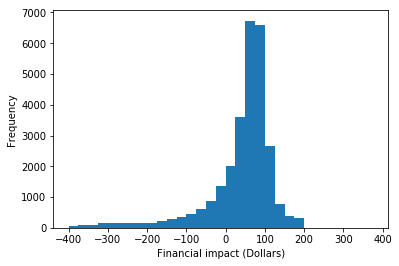

In [17]:
keyValues(data_na, collectionEfficiency, defaultBiasModifier)

The total impact seems to be heavily negative but the average impact is only 8.50 dollars per costumer. Also the dataset seems to be heavily skewed to having more defaulters so this is to be expected. 

In [18]:
#a function for calculating how much money a dataset will produce when generalized to the whole population

def bottomLine(dataset, collectEff, bias):
    impacts = []

    for i in range(0,len(dataset)):
        impacts.append(financialImpact(dataset[i,6:25], collectEff, bias))
     
    #since the filtering of credit cards decreases also the amount of credit cards in the general population
    #the amount of active credit cards must be scaled to much the effect of the filtering
    
    scaledActiveCards = activeCards * len(dataset) / (30000) 
    scaledTotalCards = totalCards * len(dataset) / (30000) 
    return sum(impacts) / (len(dataset) + 1) * scaledActiveCards + 75 * (scaledTotalCards - scaledActiveCards)

In [19]:
bottomLine(data_na, collectionEfficiency, defaultBiasModifier)

22365482.37523578

# Let's try to create some kind of filter with a desicion tree
The model is just a basic out of the box decision tree

In [20]:
geoData = data_na[:,25]
extractLatitude = lambda s: float(s.split(",")[0][1:])
extractLognitude = lambda s: float(s.split(",")[1][:-1])

extractLatitude = np.vectorize(extractLatitude)
extractLognitude = np.vectorize(extractLognitude)

latitude = extractLatitude(geoData)
lognitude = extractLognitude(geoData)

geoData = np.vstack((latitude, lognitude)).T
geoData_core = geoData[np.where((geoData[:,1] > -88) & (geoData[:,1] < -84.5) & (geoData[:,0] < 42) & (geoData[:,0] > 37.1))]
len(geoData_core)

29434

In [21]:
geoData.shape

(30000, 2)

In [22]:
data_na[:,1:24].shape

(30000, 23)

In [30]:
all_data = np.concatenate((data_na[:,1:24], geoData), 1).astype(float)
all_labels = data_na[:,24].astype(float)

x_train_all, x_test_all, y_train, y_test = train_test_split(all_data, all_labels, test_size = 0.2) 

x_train = np.delete(x_train_all, np.s_[5:23], 1)
x_test = np.delete(x_test_all, np.s_[5:23], 1)

print(x_test_all.shape)
print(np.array([y_test]).shape)
test_all = np.concatenate((np.array([y_test]).T, x_test_all[:,0:23], np.array([y_test]).T), 1)

(6000, 25)
(1, 6000)


In [24]:
print(test_all.shape)
print(data_na.shape)

(6000, 25)
(30000, 27)


In [25]:
print(test_all[0,:])
print(data_na[0,:])

[  1.00000000e+00   8.40000000e+03   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.70000000e+01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.00000000e+00
   6.35900000e+02   7.21870000e+02   8.01160000e+02   1.05858000e+03
   1.38116000e+03   2.88320000e+02   9.67700000e+01   9.67700000e+01
   3.22580000e+02   3.22580000e+02   2.88320000e+02   6.45200000e+01
   1.00000000e+00]
[1 600 2 2 1 24 2 2 -1 -1 -2 -2 126.23 100.06 22.23 0.0 0.0 0.0 0.0 22.23
 0.0 0.0 0.0 0.0 1 '"40.81610946060648, -84.9254489054052"'
 'First Bancorp of Indiana Inc']


In [171]:
model_all = GBC(n_estimators = 200, max_features = 12, max_depth = 4, min_samples_leaf = 35, min_samples_split = 100, warm_start = True)
model_all.fit(x_train_all, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=12, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=35, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=True)

In [172]:
model = GBC(n_estimators = 100, max_depth = 4, min_samples_leaf = 12, min_samples_split = 50, max_features = 4, warm_start = True)
model.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=12, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=True)

In [19]:
all_data = data_na[:,0:25].astype(float)
all_labels = data_na[:,24].astype(float)
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size = 0.3)

train_data = train_data[:,1:5]
test_data = test_data[:,1:5]

model = DecisionTreeClassifier(random_state=0)

model.fit(train_data, train_labels)

print("Score: " + str(model.score(test_data, test_labels)))

print("Confusion matrix: \n" + str(confusion_matrix(model.predict(test_data), test_labels)))

Score: 0.772222222222
Confusion matrix: 
[[6937 1976]
 [  74   13]]


## Let's try to see how the predicted probability of the model correlates with the default risk

### First with the test data

Median: 0.77047732985
Mean: 0.69921955393


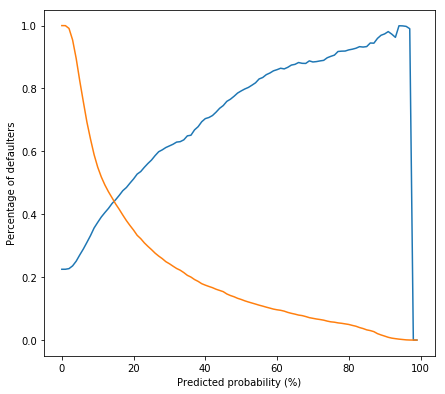

In [207]:
probabilities = model_all.predict_proba(x_test_all)

percentages = []
size = []
total = len(x_test_all)
for i in range(0,100):
    defaulters = len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 1.0)[0])
    non_defaulters =  len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 0)[0])
    percentages.append(defaulters / (defaulters + non_defaulters + 0.01))
    size.append((defaulters + non_defaulters) / total) 

np.array(percentages)
print("Median: " + str(np.median(percentages)))
print("Mean: " + str(np.mean(percentages)))
percentages[25]

plt.figure(1,(7,14))
plt.subplot(211)
plt.plot(percentages)
plt.plot(size)
plt.xlabel("Predicted probability (%)")
plt.ylabel("Percentage of defaulters")
plt.show()

In [208]:
print("Percentage of defaulters at 40% predicted probality: " + str(percentages[40]))
print("Percetage of people with 40% predicted probability: " + str(size[40]))
print("")
print("Percentage of defaulters at 30% predicted probality: " + str(percentages[30]))
print("Percetage of people with 30% predicted probability: " + str(size[30]))

Percentage of defaulters at 40% predicted probality: 0.7041917538954781
Percetage of people with 40% predicted probability: 0.17466666666666666

Percentage of defaulters at 30% predicted probality: 0.6174408142801217
Percetage of people with 30% predicted probability: 0.24266666666666667


There seems to be some correlation between the predicted probability and the predicted probability of the model. In the end there are too few people to really say are they going to default.

11
33
55
77
99


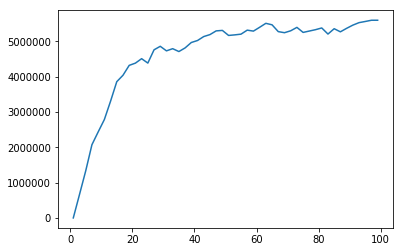

In [225]:
bottomLines = []
for i in range(1,100, 2):
    if(i % 11 == 0):
        print(i)
    survivors = test_all[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, collectionEfficiency, defaultBiasModifier))

plt.plot(list(range(1,100,2)),bottomLines)

In [224]:
bottomLine(test_all, collectionEfficiency, defaultBiasModifier)

5595925.8215863947

Median: 0.307574009996
Mean: 0.347451516065


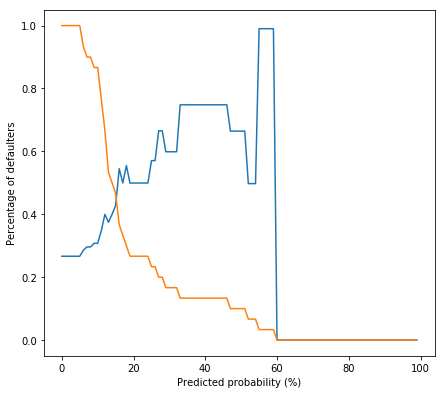

In [146]:
probabilities = model.predict_proba(x_test)

percentages = []
size = []
total = len(x_test_all)
for i in range(0,100):
    defaulters = len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 1.0)[0])
    non_defaulters =  len(np.where(y_test[np.where(probabilities[:,1] > i / 100)] == 0)[0])
    percentages.append(defaulters / (defaulters + non_defaulters + 0.01))
    size.append((defaulters + non_defaulters) / total) 

np.array(percentages)
print("Median: " + str(np.median(percentages)))
print("Mean: " + str(np.mean(percentages)))
percentages[25]

plt.figure(1,(7,14))
plt.subplot(211)
plt.plot(percentages)
plt.plot(size)
plt.xlabel("Predicted probability (%)")
plt.ylabel("Percentage of defaulters")
plt.show()

In [135]:
print("Percentage of defaulters at 40% predicted probality: " + str(percentages[40]))
print("Percetage of people with 40% predicted probability: " + str(size[40]))
print("")
print("Percentage of defaulters at 30% predicted probality: " + str(percentages[30]))
print("Percetage of people with 30% predicted probability: " + str(size[30]))

Percentage of defaulters at 40% predicted probality: 0.7481296758104738
Percetage of people with 40% predicted probability: 0.13333333333333333

Percentage of defaulters at 30% predicted probality: 0.5988023952095809
Percetage of people with 30% predicted probability: 0.16666666666666666


11
33
55
77
99


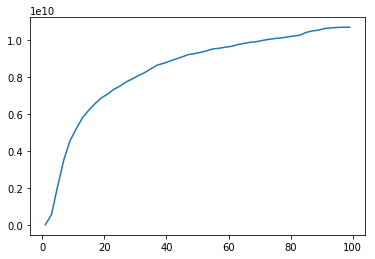

In [205]:
bottomLines = []
for i in range(1,100, 2):
    if(i % 11 == 0):
        print(i)
    survivors = test_all[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, collectionEfficiency, defaultBiasModifier))

plt.plot(list(range(1,100,2)),bottomLines)

In [159]:
len(all_data)

30000

### Whole dataset

Median: 0.529821802935
Mean: 0.496833203395
Score: 0.7798


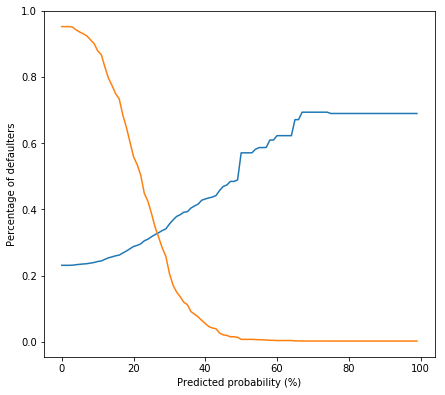

In [24]:
probabilities = model.predict_proba(all_data[:,1:5])

percentages = []
size = []
total = len(all_data)
for i in range(0,100):
    defaulters = len(np.where(all_labels[np.where(probabilities[:,1] > i / 100)] == 1.0)[0])
    non_defaulters =  len(np.where(all_labels[np.where(probabilities[:,1] > i / 100)] == 0)[0])
    percentages.append(defaulters / (defaulters + non_defaulters))
    size.append((defaulters + non_defaulters) / total) 

np.array(percentages)
print("Median: " + str(np.median(percentages)))
print("Mean: " + str(np.mean(percentages)))
print("Score: " + str(model.score(all_data[:,1:5], all_labels)))
percentages[25]

plt.figure(1,(7,14))
plt.subplot(211)
plt.plot(percentages)
plt.plot(size)
plt.xlabel("Predicted probability (%)")
plt.ylabel("Percentage of defaulters")


In [25]:
print("Percentage of defaulters at 40% predicted probality: " + str(percentages[40]))
print("Percetage of people with 40% predicted probability: " + str(size[40]))
print("")
print("Percentage of defaulters at 30% predicted probality: " + str(percentages[30]))
print("Percetage of people with 30% predicted probability: " + str(size[30]))


Percentage of defaulters at 40% predicted probality: 0.4313487241798299
Percetage of people with 40% predicted probability: 0.05486666666666667

Percentage of defaulters at 30% predicted probality: 0.35565596256253024
Percetage of people with 30% predicted probability: 0.20656666666666668


11
33
55
77
99


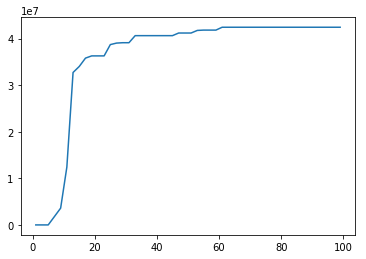

In [145]:
bottomLines = []
for i in range(1,100, 2):
    if(i % 11 == 0):
        print(i)
    survivors = all_data[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, collectionEfficiency, defaultBiasModifier))

plt.plot(list(range(1,100,2)),bottomLines)

11
33
55
77
99


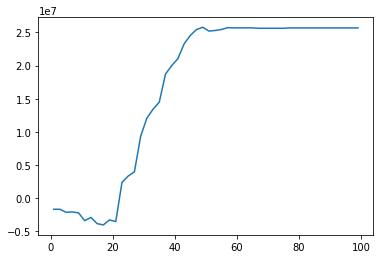

In [368]:
bottomLines = []
for i in range(1,100,2):
    if(i % 11 == 0):
        print(i)
    survivors = all_data[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, 0.6, 3))

plt.plot(list(range(1,100,2)),bottomLines)

11
33
55
77
99


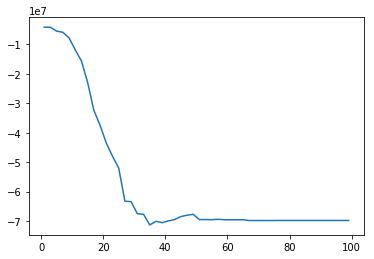

In [369]:
bottomLines = []
for i in range(1,100,2):
    if(i % 11 == 0):
        print(i)
    survivors = all_data[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, 0.1, 3))

plt.plot(list(range(1,100,2)),bottomLines)

11
33
55
77
99


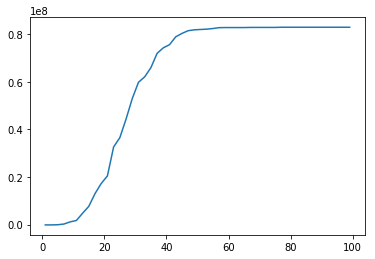

In [371]:
bottomLines = []
for i in range(1,100,2):
    if(i % 11 == 0):
        print(i)
    survivors = all_data[np.where(probabilities[:,1] < i / 100)]
    bottomLines.append(bottomLine(survivors, 0.9, 3))

plt.plot(list(range(1,100,2)),bottomLines)

In the last two imges we can see the basic trend in this model. If you can retrieve most of your money on default, you should offer many credit cards. If you lose most of your money on default, tou shouldn't give out any credit cards since they are bad business. 

Based on this classifier there is no point in discriminating anyone. However this is just a quick mockup model, but with a better classification algorithm it could be possible to derive benefit from this. 

## Clustering using the geo data

In [31]:
geoData = data_na[:,25]
extractLatitude = lambda s: float(s.split(",")[0][1:])
extractLognitude = lambda s: float(s.split(",")[1][:-1])

extractLatitude = np.vectorize(extractLatitude)
extractLognitude = np.vectorize(extractLognitude)

latitude = extractLatitude(geoData)
lognitude = extractLognitude(geoData)

geoData = np.vstack((latitude, lognitude)).T
geoData_core = geoData[np.where((geoData[:,1] > -88) & (geoData[:,1] < -84.5) & (geoData[:,0] < 42) & (geoData[:,0] > 37.1))]
len(geoData_core)


29434

In [32]:
db = DBSCAN(eps = 0.01, min_samples = 10).fit(geoData_core)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

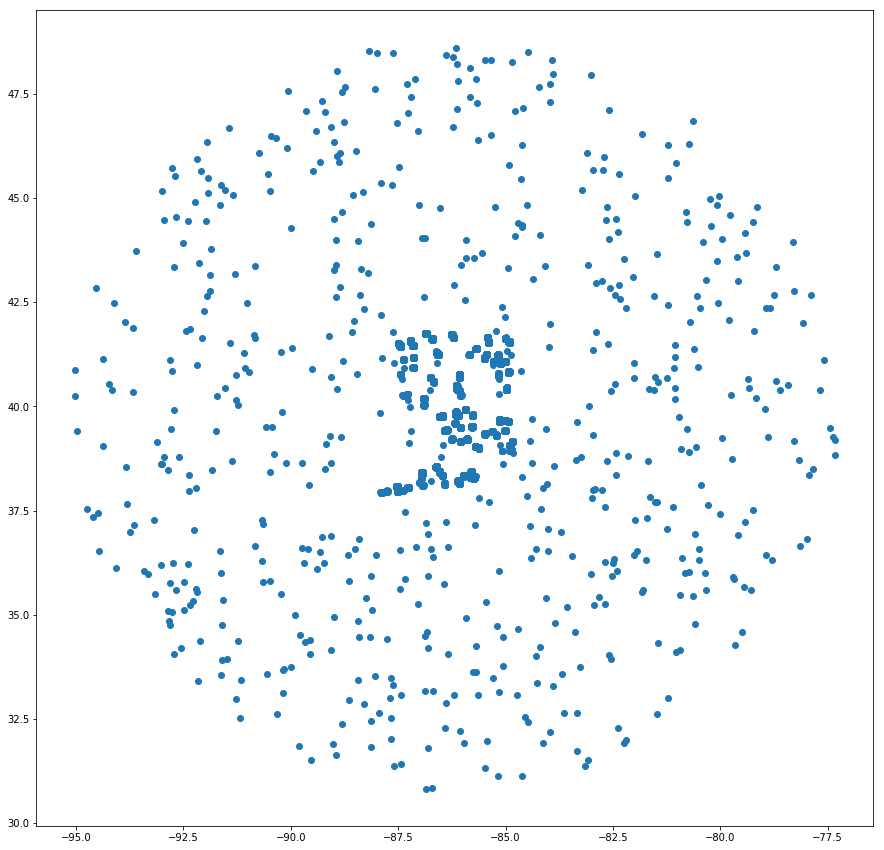

In [33]:
plt.figure(1,(15,15))
plt.scatter(geoData[:,1], geoData[:,0])

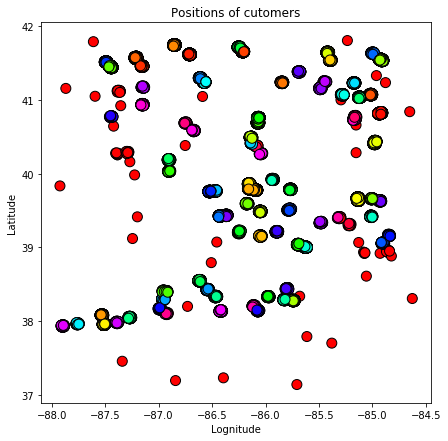

In [39]:
plt.figure(1,(7,7))
plt.scatter(geoData_core[:,1], geoData_core[:,0], s = 100,marker = 'o', edgecolors = "k", c = labels, cmap = 'hsv')
plt.xlabel("Lognitude")
plt.ylabel("Latitude")
plt.title("Positions of cutomers")
plt.savefig("Map.png", dpi = 300)

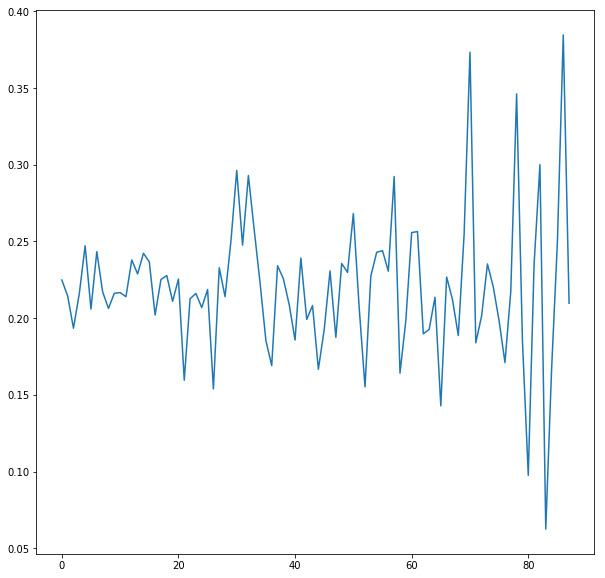

In [35]:
labels = db.labels_

unique_labels = set(labels)

defaults_per_cluster = []
sizes = []
for i in unique_labels:
    cluster = data_na[np.where(labels == i)]
    defaults = len(cluster[np.where(cluster[:,24] == 1)])
    defaults_per_cluster.append(defaults / len(cluster))
    sizes.append(len(cluster))
    
plt.figure(1,(10,10))    
plt.plot(defaults_per_cluster)

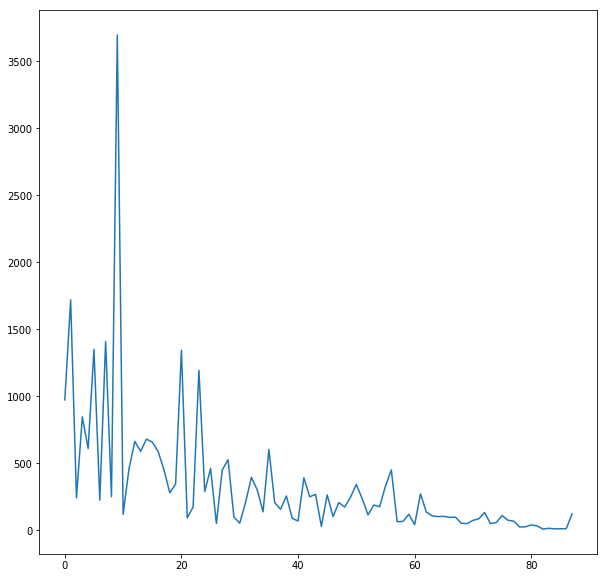

In [206]:
plt.figure(1,(10,10))
plt.plot(sizes)

(array([  1.,   0.,   1.,   0.,   1.,   2.,   6.,   7.,  12.,  19.,  19.,
          9.,   4.,   0.,   4.,   0.,   0.,   1.,   0.,   2.]),
 array([ 0.0625    ,  0.07860577,  0.09471154,  0.11081731,  0.12692308,
         0.14302885,  0.15913462,  0.17524038,  0.19134615,  0.20745192,
         0.22355769,  0.23966346,  0.25576923,  0.271875  ,  0.28798077,
         0.30408654,  0.32019231,  0.33629808,  0.35240385,  0.36850962,
         0.38461538]),
 <a list of 20 Patch objects>)

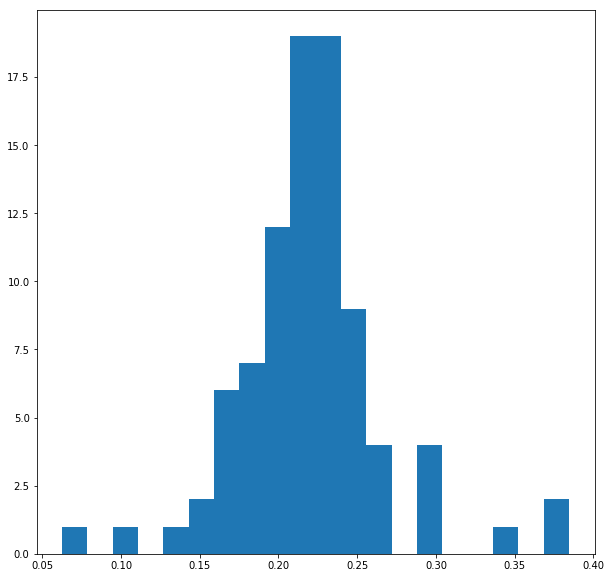

In [199]:
plt.figure(1,(10,10))
plt.hist(defaults_per_cluster, bins = 20)

29434


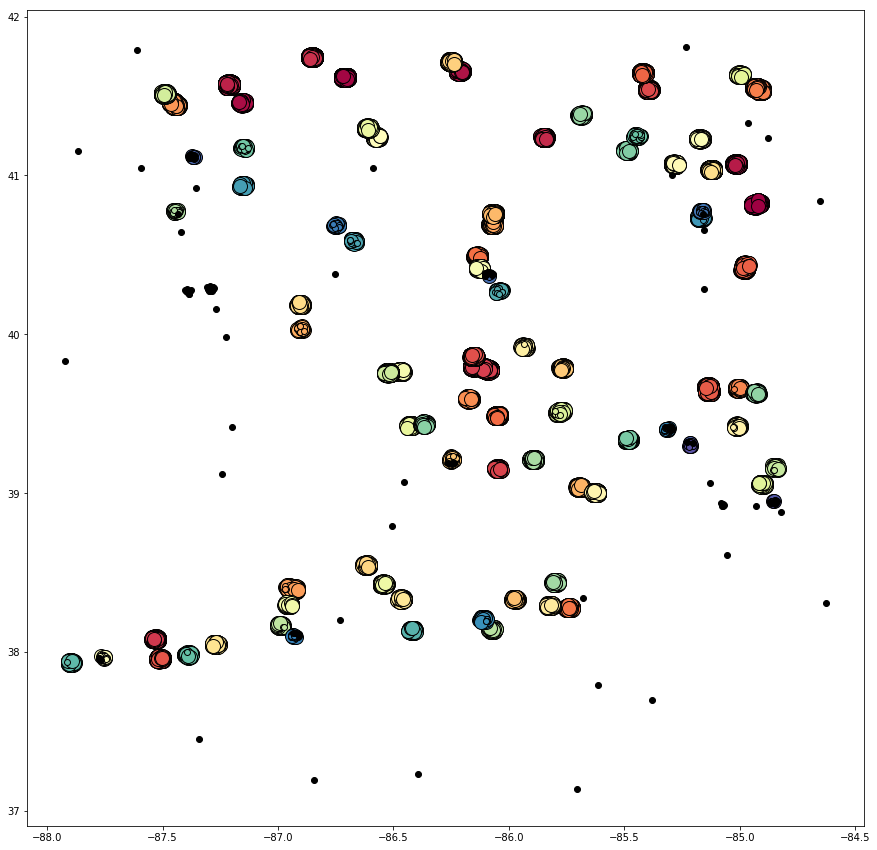

In [207]:
labels = db.labels_

unique_labels = set(labels)

plt.figure(1,(15,15))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = geoData_core[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = geoData_core[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

print(len(labels))

In [173]:
len(unique_labels)

88

In [245]:
new_data = np.concatenate((all_data[:,1:24], geoData), 1)

x_train, x_test, y_train, y_test = train_test_split(new_data, all_labels) 

In [248]:
lr_model = LR()
lr_fit = lr_model.fit(x_train, y_train)

#Score the logistic regression model
lr_score = lr_fit.score(x_test, y_test)
print("LR score: " + str(lr_score)) 
confusion_matrix(lr_model.predict(new_data), all_labels)

LR score: 0.811333333333


array([[22711,  5027],
       [  653,  1609]])

In [85]:
lda_model = LDA()
lda_fit = lda_model.fit(x_train, y_train)

#Score the logistic regression model
lda_score = lda_fit.score(x_test, y_test)
print("LDA score: " + str(lda_score)) 
confusion_matrix(lda_model.predict(new_data), all_labels)

NameError: name 'x_train' is not defined

# The Model

In [87]:
# Load the data
df = pd.read_csv("data_set_continuous.csv") # For my Macbook
# df = pd.read_csv("...") # For my Windows PC
df.head(5)

FileNotFoundError: File b'data_set_continuous.csv' does not exist

In [76]:
# Prepare data for training
features = ['Sex','Education','Married','Age_categorical','Balance_categorical','Location2']
X = df[features].copy()
y = df['Default'].copy()

In [77]:
# Let's split the data by first splitting it into two groups (24000 and 6000) then divide the first split into two
testsize = (6/30)
random = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=random)

In [78]:
# Split the 24000 into two
half = int(len(X_train)/2)
fullLength = int(len(X_train))
split1 = list(range(0,half))
split2 = list(range(half,fullLength))

# Define training sets 1 and 2
# The third set of 6000 is x_test,y_test
X_train_1 = X_train.iloc[split1]
X_train_2 = X_train.iloc[split2]
y_train_1 = y_train.iloc[split1]
y_train_2 = y_train.iloc[split2]
# Check sizes
print('X_train 1, X_train_2 lengths:')
print(len(X_train_1),len(X_train_2))
print('y_train_1, y_train_2 lengths:')
print(len(y_train_1),len(y_train_2))
print('X_test, y_test lengths:')
print(len(X_test),len(y_test))

X_train 1, X_train_2 lengths:
12000 12000
y_train_1, y_train_2 lengths:
12000 12000
X_test, y_test lengths:
6000 6000


In [89]:
# Train the decision tree
dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_leaf=100)
dt.fit(X_train_1,y_train_1)

NameError: name 'tree' is not defined

In [ ]:
data_pd = pd.read_csv("dataset_raw.csv")
data = np.array(data_pd)